In [3]:
from shapely.geometry import Polygon, Point, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import random

In [4]:
# Create polygons and points
polygon = Polygon([(10, 0), (10, 100), (0, 200), (60, 200), (50, 100), (50, 0)])
# TODO: Randomize start and end point on the bound
start = Point((20, 0))
end = Point((30, 200))

In [5]:
# Find m and b
def fx(p1, p2):
    # m = (y1 - y2) / (x1 - x2)
    if (p1.x - p2.x) != 0:
        m = (p1.y - p2.y) / (p1.x - p2.x)
    else:
        m = 0
    print("m =", m)
    # b = y - mx
    b = p1.y - (m * p1.x)
    print("b =", b)

    return m, b


In [6]:
# Find distance from point to line
# Equations to find point to line:
# +=d = (mx3 - y3 + C) / ((m^2 + 1)) ^ 0.5
def distance(point, m, b):
    x = point.x
    y = point.y
    d = (m * x - y + b) / ((m ** 2 + 1)) ** 0.5
    return d

In [67]:
# D = sqrt((start.x - point.x)^2 + (start.y - point.y)^2)
def pointsOnLine(start, end, n):
    pointsOL = []
    line = LineString([start, end])
    gap = 1 / (n + 1)
    d = gap
    for i in range(n):
        point = line.interpolate(d, normalized=True)
        d = d + gap
        pointsOL.append(point)
    pointsOL.append(end)
    return pointsOL
    

In [68]:
# Rotate points +-90 degrees
def pointRotate(origin, end, degree=90, d=0.1):
    line = LineString([origin, end])
    point = line.interpolate(d, normalized=True)
    rotated_point = affinity.rotate(point, degree, origin=origin)
    return rotated_point

In [99]:
def shiftedPoints(polygon, start, end, n):
    points = pointsOnLine(start, end, n)
    print(len(points))
    # rotate points[]
    new_points = []
    for i in range(len(points)):
        if i == len(points) - 1:
            new_point = pointRotate(points[i], points[i-1], degree=-90, d=0.05*i**1.3)
            print(0.1*i**1.2)
            new_points.append(new_point)
        else:
            new_point = pointRotate(points[i], points[i+1], d=0.05*i**1.3)
            print(0.1*i**1.2)
            new_points.append(new_point)
    return new_points
    

11
0.0
0.1
0.22973967099940698
0.3737192818846552
0.5278031643091577
0.6898648307306074
0.8585814486631533
1.0330412131161866
1.2125732532083184
1.3966610165238236
1.5848931924611134


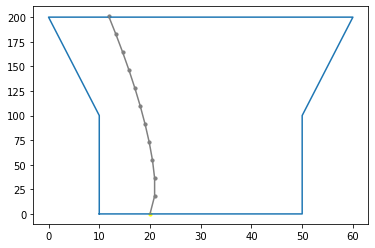

In [101]:
new_points = shiftedPoints(polygon, start, end, 10)
# Plot polygons and points
x,y = polygon.exterior.xy
plt.plot(x,y)
line_x = [start.x]
line_y = [start.y]
for i in range(len(new_points)):
    line_x.append(new_points[i].x)
    line_y.append(new_points[i].y)
    plt.scatter(new_points[i].x, new_points[i].y, s=10, color='grey')

plt.scatter(start.x, start.y, s=10, color='yellow')        
#plt.scatter(end.x, end.y, s=10, color='green')
#line_x.append(end.x)
#line_y.append(end.y)
plt.plot(line_x, line_y, color='grey')

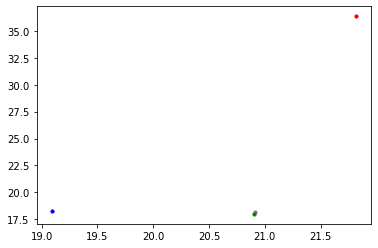

In [92]:
# testing pointRotate()
point_a = points[0]
point_b = points[1]
#plt.scatter(start.x, start.y, s=10, color='yellow')
#plt.scatter(end.x, end.y, s=10, color='green')
plt.scatter(point_a.x, point_a.y, s=10, color='grey')
plt.scatter(point_b.x, point_b.y, s=10, color='red')
#for i in range(12):
#    rotated_a = pointRotate(point_a, point_b, degree=i*15)
#    plt.scatter(rotated_a.x, rotated_a.y, s=5, color='red')
rotated_point = pointRotate(point_a, point_b)
plt.scatter(rotated_point.x, rotated_point.y, s=10, color='blue')
rot_blue = pointRotate(point_a, rotated_point)
plt.scatter(rot_blue.x, rot_blue.y, s=10, color='green')



3